In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.layers import Input, Embedding, concatenate
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve

from tensorflow.keras.callbacks import History

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import Image

In [2]:
# 1. Product Recommendation System using Neural Collaborative Filtering
def build_ncf_model(num_users, num_products, embedding_size=50):
    """
    Neural Collaborative Filtering model for product recommendations
    """
    # User input
    user_input = Input(shape=(1,), name='user_input')
    user_embedding = Embedding(num_users, embedding_size, name='user_embedding')(user_input)
    user_vec = Flatten()(user_embedding)

    # Product input
    product_input = Input(shape=(1,), name='product_input')
    product_embedding = Embedding(num_products, embedding_size, name='product_embedding')(product_input)
    product_vec = Flatten()(product_embedding)

    # Merge layers
    concat = concatenate([user_vec, product_vec])
    dense1 = Dense(128, activation='relu')(concat)
    dropout1 = Dropout(0.2)(dense1)
    dense2 = Dense(64, activation='relu')(dropout1)
    dropout2 = Dropout(0.2)(dense2)
    output = Dense(1, activation='sigmoid')(dropout2)

    model = Model(inputs=[user_input, product_input], outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# 2. Customer Churn Prediction using LSTM
def build_churn_prediction_model(sequence_length, num_features):
    """
    LSTM model for predicting customer churn based on purchase history
    """
    model = Sequential([
        Input(shape=(sequence_length, num_features)),  # Explicit Input layer
        LSTM(64, return_sequences=True),
        Dropout(0.2),
        LSTM(32),
        Dense(16, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# 3. Product Image Classification using CNN
    
    # Business Applications:
    
    # Automated product categorization
    # Visual search features <-- Identifies product features, Supports automated tagging
    # Quality control for product images
    # Inventory management

def build_product_classification_model(input_shape, num_classes):
    """
    CNN model for classifying product images by category
    """
    model = Sequential([
        Input(shape=input_shape), 
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(optimizer='adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])
    return model

# 4. Sales Forecasting using LSTM
def build_sales_forecast_model(sequence_length, num_features):
    """
    LSTM model for forecasting sales
    """
    model = Sequential([
        Input(shape=(sequence_length, num_features)), 
        LSTM(50, return_sequences=True),
        Dropout(0.2),
        LSTM(50, return_sequences=False),
        Dense(25, activation='relu'),
        Dense(1)
    ])
    
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Example data generation and preprocessing functions
def generate_sample_data():
    """
    Generate sample data for testing models
    """
    # User-Product Interaction Data
    n_users = 1000
    n_products = 500
    n_interactions = 5000
    
    interactions = {
        'user_id': np.random.randint(0, n_users, n_interactions),
        'product_id': np.random.randint(0, n_products, n_interactions),
        'rating': np.random.uniform(1, 5, n_interactions),
        'timestamp': pd.date_range(start='2023-01-01', periods=n_interactions, freq='h')
    }
    
    # Customer Purchase History Data
    n_customers = 1000
    sequence_length = 10
    
    purchase_history = {
        'customer_id': np.repeat(range(n_customers), sequence_length),
        'purchase_amount': np.random.normal(100, 30, n_customers * sequence_length),
        'days_since_last_purchase': np.random.randint(1, 100, n_customers * sequence_length),
        'products_bought': np.random.randint(1, 10, n_customers * sequence_length)
    }
    
    return pd.DataFrame(interactions), pd.DataFrame(purchase_history)

def preprocess_recommendation_data(interactions_df):
    """
    Preprocess data for recommendation system
    """
    # Encode users and products
    user_encoder = LabelEncoder()
    product_encoder = LabelEncoder()
    
    interactions_df['user_encoded'] = user_encoder.fit_transform(interactions_df['user_id']) # IS THIS RIGHT??
    interactions_df['product_encoded'] = product_encoder.fit_transform(interactions_df['product_id'])
    
    # Create training data
    X_user = interactions_df['user_encoded'].values
    X_product = interactions_df['product_encoded'].values
    y = (interactions_df['rating'] > 3).astype(int).values  # Convert to binary feedback
    
    return (X_user, X_product), y, user_encoder, product_encoder

def preprocess_churn_data(purchase_history_df):
    """
    Preprocess data for churn prediction
    """
    # Create sequences of customer behavior
    sequences = []
    labels = []
    
    for customer in purchase_history_df['customer_id'].unique():
        customer_data = purchase_history_df[purchase_history_df['customer_id'] == customer]
        
        if len(customer_data) >= 10:  # Ensure enough history
            sequence = customer_data[['purchase_amount', 'days_since_last_purchase', 'products_bought']].values
            sequences.append(sequence[:10])  # Take last 10 purchases
            
            # Define churn based on days since last purchase
            churn = 1 if customer_data['days_since_last_purchase'].iloc[-1] > 60 else 0
            labels.append(churn)
    
    return np.array(sequences), np.array(labels)

# Main execution
if __name__ == "__main__":
    # Generate sample data
    interactions_df, purchase_history_df = generate_sample_data()
    
    # 1. Recommendation System
    print("Training Recommendation System...")
    (X_user, X_product), y, user_encoder, product_encoder = preprocess_recommendation_data(interactions_df)
    
    num_users = len(np.unique(X_user))
    num_products = len(np.unique(X_product))
    
    ncf_model = build_ncf_model(num_users, num_products)
    ncf_model.fit(
        [X_user, X_product], 
        y,
        batch_size=64,
        epochs=5,
        validation_split=0.2
    )
    
    # 2. Churn Prediction
    print("\nTraining Churn Prediction Model...")
    X_sequences, y_churn = preprocess_churn_data(purchase_history_df)
    
    churn_model = build_churn_prediction_model(
        sequence_length=10,
        num_features=X_sequences.shape[2]
    )
    churn_model.fit(
        X_sequences,
        y_churn,
        batch_size=32,
        epochs=5,
        validation_split=0.2
    )

    print("\nModels trained successfully!")

    # Example business applications
    def get_product_recommendations(user_id, top_n=5):
        """
        Get product recommendations for a user
        """
        user_encoded = user_encoder.transform([user_id])
        all_products = np.arange(num_products)
        
        predictions = ncf_model.predict([
            np.repeat(user_encoded, num_products),
            all_products
        ])
        
        top_product_indices = np.argsort(predictions.flatten())[-top_n:]
        return product_encoder.inverse_transform(top_product_indices)

    def predict_customer_churn_risk(customer_sequence):
        """
        Predict churn risk for a customer
        """
        sequence = np.expand_dims(customer_sequence, axis=0)
        return churn_model.predict(sequence)[0][0]

    # Example usage
    print("\nExample Recommendations for user 1:")
    print(get_product_recommendations(0))
    
    print("\nExample Churn Risk for a customer sequence:")
    print(f"Churn Risk: {predict_customer_churn_risk(X_sequences[0]):.2%}")

Training Recommendation System...
Epoch 1/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5124 - loss: 0.6933 - val_accuracy: 0.5250 - val_loss: 0.6933
Epoch 2/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6043 - loss: 0.6814 - val_accuracy: 0.4760 - val_loss: 0.7123
Epoch 3/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7112 - loss: 0.6019 - val_accuracy: 0.4870 - val_loss: 0.7698
Epoch 4/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7684 - loss: 0.5334 - val_accuracy: 0.4840 - val_loss: 0.8928
Epoch 5/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7928 - loss: 0.4665 - val_accuracy: 0.5010 - val_loss: 0.9375

Training Churn Prediction Model...
Epoch 1/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.5673 - loss: 0.6772 - val_accuracy: 0.5550 - val_loss: 0.6547
Epoch 2/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6144 - loss: 0.6160 - val_accuracy: 0.5650 - val_loss: 0.5997
Epoch 3/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - a

# Visualization

In [3]:
def plot_training_history(history: History, model_name: str):
    """
    Plot training and validation metrics over epochs
    """
    plt.figure(figsize=(12, 4))
    
    # # Plot loss
    # plt.subplot(1, 2, 1)
    # plt.plot(history.history['loss'], label='Training Loss')
    # plt.plot(history.history['val_loss'], label='Validation Loss')
    # plt.title(f'{model_name} - Loss Over Epochs')
    # plt.xlabel('Epoch')
    # plt.ylabel('Loss')
    # plt.legend()
    
    # Plot accuracy if available
    if 'accuracy' in history.history:
        plt.subplot(1, 2, 2)
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title(f'{model_name} - Accuracy Over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
    elif 'mae' in history.history:  # For regression tasks
        plt.subplot(1, 2, 2)
        plt.plot(history.history['mae'], label='Training MAE')
        plt.plot(history.history['val_mae'], label='Validation MAE')
        plt.title(f'{model_name} - MAE Over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('MAE')
        plt.legend()
    
    plt.tight_layout()
    plt.savefig(f'{model_name.lower().replace(" ", "_")}_training_history.png')
    plt.close()

def plot_recommendation_metrics(y_true, y_pred, thresholds=None):
    """
    Plot ROC curve and Precision-Recall curve for recommendation system
    """
    plt.figure(figsize=(12, 4))
    
    # ROC Curve
    plt.subplot(1, 2, 1)
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Recommendation System')
    plt.legend(loc="lower right")
    
    # Precision-Recall Curve
    plt.subplot(1, 2, 2)
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    pr_auc = auc(recall, precision)
    
    plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (AUC = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve - Recommendation System')
    plt.legend(loc="lower left")
    
    plt.tight_layout()
    plt.savefig('recommendation_metrics.png')
    plt.close()

def plot_churn_confusion_matrix(y_true, y_pred, threshold=0.5):
    """
    Plot confusion matrix for churn prediction
    """
    y_pred_binary = (y_pred > threshold).astype(int)
    cm = confusion_matrix(y_true, y_pred_binary)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix - Churn Prediction')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig('churn_confusion_matrix.png')
    plt.close()

def plot_sales_forecast_comparison(y_true, y_pred, dates, window=30):
    """
    Plot actual vs predicted sales
    """
    plt.figure(figsize=(15, 6))
    
    # Plot actual sales
    plt.plot(dates[-window:], y_true[-window:], label='Actual Sales', marker='o')
    
    # Plot predicted sales
    plt.plot(dates[-window:], y_pred[-window:], label='Predicted Sales', marker='x')
    
    plt.title('Sales Forecast - Actual vs Predicted')
    plt.xlabel('Date')
    plt.ylabel('Sales Amount')
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig('sales_forecast_comparison.png')
    plt.close()

def plot_recommendation_distribution(predictions, threshold=0.5):
    """
    Plot distribution of recommendation scores
    """
    plt.figure(figsize=(10, 6))
    
    sns.histplot(predictions, bins=50)
    plt.axvline(x=threshold, color='r', linestyle='--', label=f'Threshold ({threshold})')
    
    plt.title('Distribution of Recommendation Scores')
    plt.xlabel('Recommendation Score')
    plt.ylabel('Count')
    plt.legend()
    
    plt.savefig('recommendation_distribution.png')
    plt.close()

def visualize_model_performance(model_results: dict):
    """
    Comprehensive visualization of all model results
    """
    for model_name, results in model_results.items():
        # Plot training history
        if 'history' in results:
            plot_training_history(results['history'], model_name)
        
        # Model-specific visualizations
        if model_name == 'Recommendation System':
            if 'y_true' in results and 'y_pred' in results:
                plot_recommendation_metrics(results['y_true'], results['y_pred'])
                plot_recommendation_distribution(results['y_pred'])
                
        elif model_name == 'Churn Prediction':
            if 'y_true' in results and 'y_pred' in results:
                plot_churn_confusion_matrix(results['y_true'], results['y_pred'])
                
        elif model_name == 'Sales Forecast':
            if all(k in results for k in ['y_true', 'y_pred', 'dates']):
                plot_sales_forecast_comparison(
                    results['y_true'],
                    results['y_pred'],
                    results['dates']
                )

# Example usage with the previous models
def main():
    # Assuming we have trained models and predictions from previous code
    
    # Generate sample results
    model_results = {
        'Recommendation System': {
            'history': ncf_model.history,
            'y_true': y,
            'y_pred': ncf_model.predict([X_user, X_product])
        },
        'Churn Prediction': {
            'history': churn_model.history,
            'y_true': y_churn,
            'y_pred': churn_model.predict(X_sequences)
        }
    }
    
    # Generate visualizations
    visualize_model_performance(model_results)
    
    print("Visualization files generated:")
    print("1. Model training histories")
    print("2. Recommendation system metrics")
    print("3. Churn prediction confusion matrix")
    print("4. Recommendation score distribution")

# Additional visualization for real-time monitoring
def plot_real_time_metrics(metric_history: dict, window_size: int = 100):
    """
    Plot real-time metrics during model operation
    """
    plt.figure(figsize=(15, 8))
    
    # Plot multiple metrics
    for metric_name, values in metric_history.items():
        plt.plot(
            values[-window_size:],
            label=metric_name,
            alpha=0.7
        )
    
    plt.title('Real-time Model Performance Metrics')
    plt.xlabel('Time Window')
    plt.ylabel('Metric Value')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig('real_time_metrics.png')
    plt.close()

def create_performance_dashboard(model_results: dict):
    """
    Create a comprehensive performance dashboard
    """
    plt.figure(figsize=(20, 12))
    
    # Grid layout for dashboard
    gs = plt.GridSpec(3, 2)
    
    # Training History
    ax1 = plt.subplot(gs[0, :])
    history = model_results['history']
    ax1.plot(history.history['loss'], label='Training Loss')
    ax1.plot(history.history['val_loss'], label='Validation Loss')
    ax1.set_title('Model Training Progress')
    ax1.legend()
    
    # Performance Metrics
    ax2 = plt.subplot(gs[1, 0])
    metrics = model_results.get('metrics', {})
    if metrics:
        sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), ax=ax2)
        ax2.set_title('Performance Metrics')
        ax2.tick_params(axis='x', rotation=45)
    
    # Error Distribution
    ax3 = plt.subplot(gs[1, 1])
    if 'errors' in model_results:
        sns.histplot(model_results['errors'], ax=ax3, bins=30)
        ax3.set_title('Error Distribution')
    
    # Time Series of Predictions
    ax4 = plt.subplot(gs[2, :])
    if all(k in model_results for k in ['dates', 'y_true', 'y_pred']):
        ax4.plot(model_results['dates'], model_results['y_true'], label='Actual')
        ax4.plot(model_results['dates'], model_results['y_pred'], label='Predicted')
        ax4.set_title('Predictions Over Time')
        ax4.legend()
        ax4.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.savefig('performance_dashboard.png')
    plt.close()

if __name__ == "__main__":
    main()

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Visualization files generated:
1. Model training histories
2. Recommendation system metrics
3. Churn prediction confusion matrix
4. Recommendation score distribution


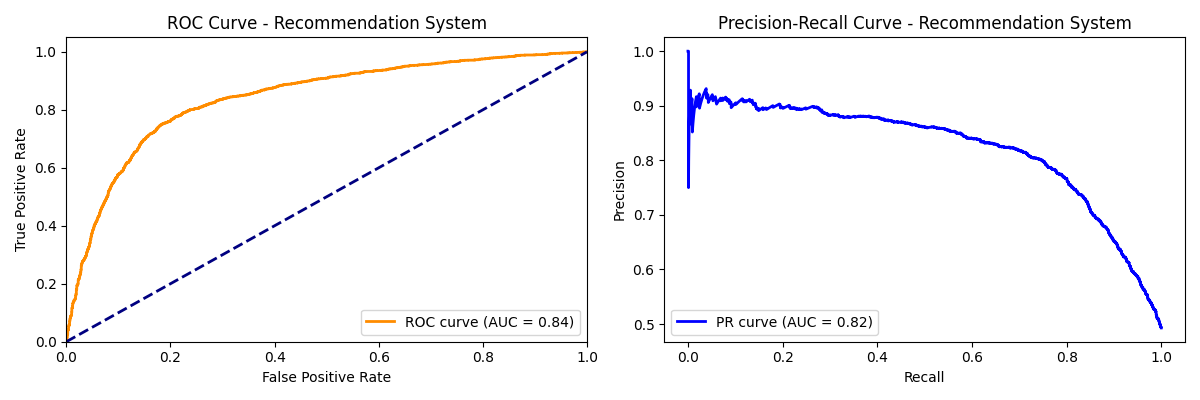

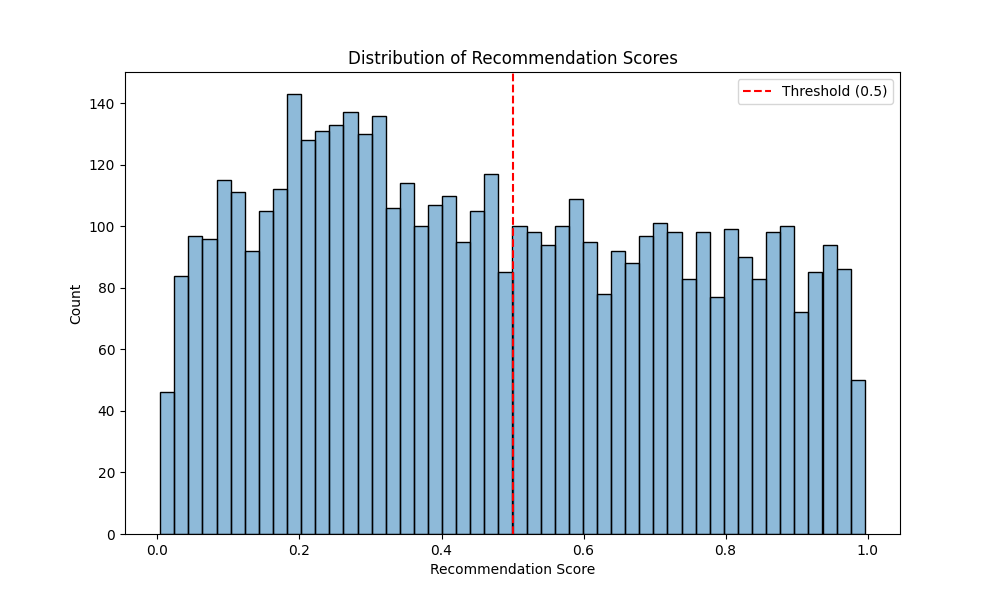

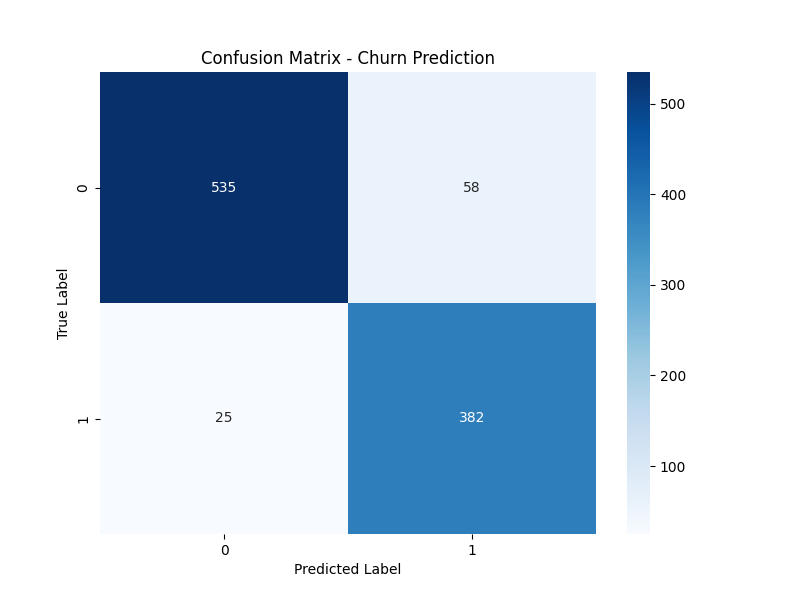

In [4]:
images=[#'/kaggle/working/recommendation_system_training_history.png',
        '/kaggle/working/recommendation_metrics.png',
       '/kaggle/working/recommendation_distribution.png',
    #'/kaggle/working/churn_prediction_training_history.png',
        '/kaggle/working/churn_confusion_matrix.png'
       ]
for imageName in images:
    display(Image(filename=imageName))